(unsupervised:som)=
# Self-Organizing Maps

Self-organizing maps (SOMs), also known as Kohonen networks, appeared in the 1980s. In contrast to all other dimensionality reduction techniques discussed up to now, SOMs drop the requirement that the low dimensional version of a data set has to have as many points as the original data set.
Instead, SOMs allow to choose the number of points in low dimensions and then try to find a topology preserving mapping between low and high dimensional data. Here, preservation of topology means preservation of neighborhood relations. Neighboring points in low dimensions are mapped to neighboring points in high dimensions.

A motivation for SOMs can be found in biology. Like artificial neural networks they are inspired by insights into the human brain, see [lateral inhibition](https://en.wikipedia.org/wiki/Lateral_inhibition) for details.
For this reason some people classify SOMs as a kind of ANNs, but structure and training differ a lot from usual ANNs.

## SOM Structure

Let $p$ be the dimension of the low dimensional space (almost always $p=2$, sometimes $p=1$ or $p=3$) and let $q$ be the desired number of data points $u_1,\ldots,u_q\in\mathbb{R}^p$ in low dimensions. Assign fixed locations to all low dimensional points in $\mathbb{R}^p$. Usually, the $u_1,\ldots,u_q$ are arranged in a regular rectangular or hexagonal grid. These positions will never change.

A SOM maps each $u_i$ into the high dimensional data space by assigning a corresponding weight $w_i\in\mathbb{R}^m$. Although the images of the $u_i$ are called weight, the $w_i$ simply are points in the high dimensional data space. The aim of SOM training is to choose weights scattered over the whole high dimensional data set, but preserving the low dimensional neighborhood relations.

```{figure} som1d.svg
---
alt: SOM in one dimension
---
SOMS approxiate high dimensional data by a low dimensional grid of points.
```

The $u_i$ do not contain any information about the data set. To visualize a SOM we have to visualize properties of the weights $w_i$ in the regular grid defined by the $u_i$ (see below).

## Training

Fitting weights $w_1,\ldots,w_q$ to the data set $x_1,\ldots,x_n$ is done iteratively:
* Choose random initial weights (or create a grid in the $p$ dimensional PCA manifold).
* Iterate over all samples:
  * Find the $w_i$ closest to the current sample.
  * Move the best matching $w_i$ and its neighbors closer to the current sample.
* Stop iteration if change of weights is small.

Moving weights towards the current sample is done via a neighborhood function $h:\mathbb{R}^p\rightarrow\mathbb{R}$, which typically takes values in $[0, 1]$ but in some cases may attain small negative values, too. Examples are Gaussian bells or the [Mexican hat](https://en.wikipedia.org/wiki/Ricker_wavelet). If $w_i$ is the best matching weight for the current sample $x_l$, the update rule for all weights is
\begin{equation*}
w_j^\mathrm{new}:=w_j^\mathrm{old}+\alpha\,h\left(\frac{1}{r}\,(u_j-u_i)\right)\,(x_l-w_j^\mathrm{old}).
\end{equation*}
The parameter $r>0$ controls the size of the neighborhood. The parameter $\alpha\in(0, 1]$ controls the attracting force of $x_l$.

Training usually starts with high values for $r$ and $\alpha$ to capture the data set's rough structure in few iterations. Then both values are decreased to allow for accurate fitting of the SOM to the data.

Batch training is possible, too. Here several samples are processed at once. For each sample the closest weight is determined. Then all weights are updated.

## Prediction

With a trained SOM we may assign high dimensional data points to low dimensional grid points. This is also true for data not available during training. The chosen grid point is the one with weight closest to the sample under consideration.

Each low dimensional grid point may be regarded as a cluster of high dimensional points. The described mapping from high to low dimensions simply is 1-NN with the weights as training data.

## Visualization

A straight forward SOM visualization is to color code a selected feature (component of the weights) in the low dimensional grid. This yields as many visualizations as there are dimensions in the data space.

To get some distance information from a SOM one may calculate Euclidean distances between weights of neighboring grid points and visualize those distances on the grid. The result is known as *unified distance matrix* (U-matrix). Dark (low values) areas indicate samples belonging to one cluster and light (high values) areas indicate boundaries between clusters. From the U-matrix one may extract clusters by applying standard image processing algorithms.

Many other kinds of visualizations may be useful, but details depend on the data set under consideration.

## SOMs with Python

Scikit-Learn does not support SOMs. But there are lots of Python modules for SOMs, for instance
* [`sklearn-som`](https://pypi.org/project/sklearn-som/),
* [`MiniSom`](https://github.com/JustGlowing/minisom),
* [`SOMPY`](https://github.com/sevamoo/SOMPY),
* [`SimpSOM`](https://github.com/fcomitani/simpsom),
* [`somoclu`](https://somoclu.readthedocs.io/en/stable/index.html).

The first one focuses on clustering and lacks some more general features like direct access to the weights. `MiniSam` and `SOMPY` come without documentation. Usage has to be deduced from provided code examples. `SimpSOM` has at least some basic documention, but implementation is incomplete. The last one, `somoclu`, is a Python wrapper for an advanced stand-alone SOM software. It's well documented, so we use `somoclu` here. Implementation details may be found in [somoclu: An Efficient Parallel Library for Self-Organizing Maps](https://www.jstatsoft.org/article/download/v078i09/1125).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import somoclu

In [2]:
file = 'clouds.npz'

loaded = np.load(file)
x = loaded['x']
y = loaded['y']
z = loaded['z']
red = loaded['red']
green = loaded['green']
blue = loaded['blue']

fig = go.Figure(layout_width=800, layout_height=600, layout_scene_aspectmode='cube')
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker={'size': 2, 'color': [f'rgb({r},{g},{b})' for r, g, b in zip(red, green, blue)]},
    hoverinfo = 'none'
))
fig.show()

In [3]:
cols = 30
rows = 30

som = somoclu.Somoclu(cols, rows, initialization='pca')
som.train(np.stack((x, y, z), axis=1), epochs=1000)

U-matrix


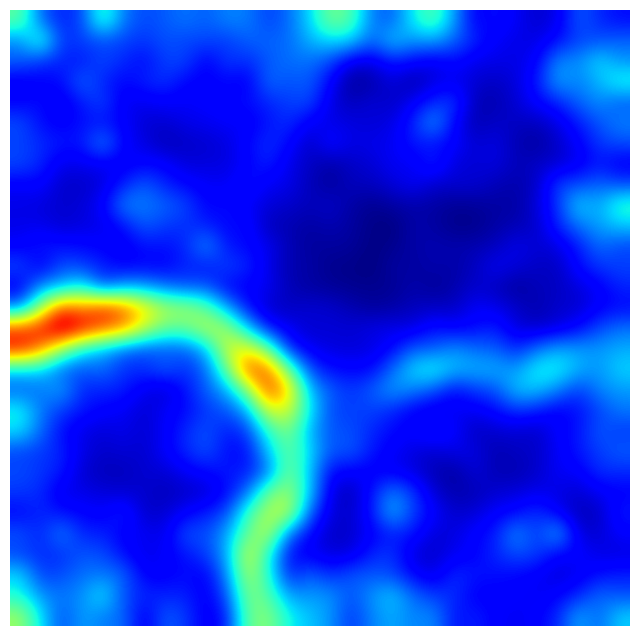

3x components of weight vectors


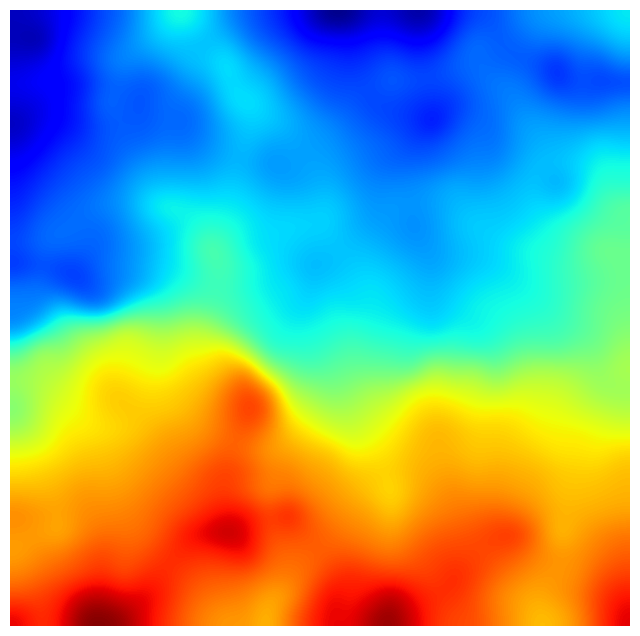

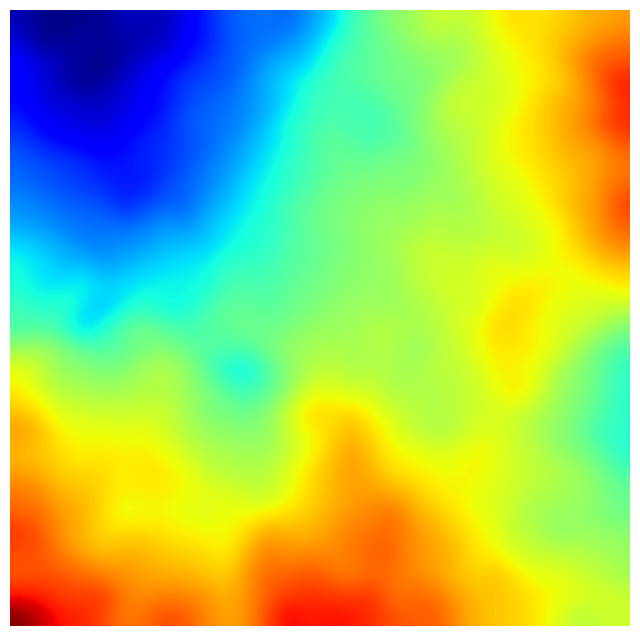

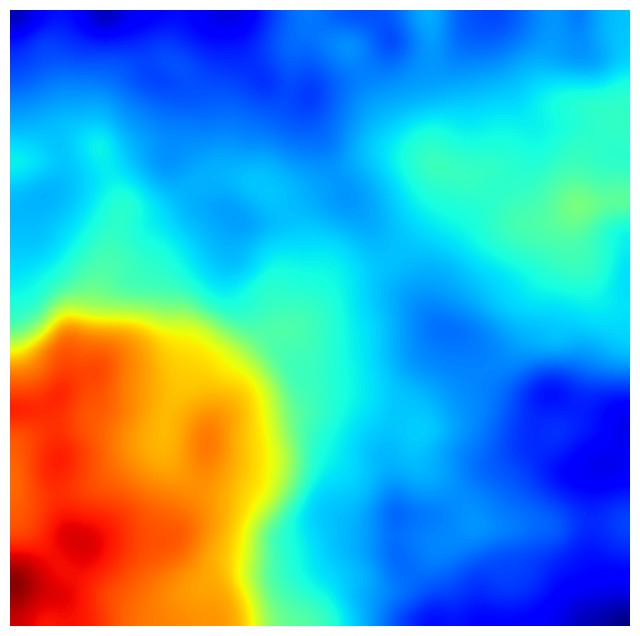

<module 'matplotlib.pyplot' from '/home/jef19jdw/anaconda3/envs/ds_book/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [4]:
print('U-matrix')
som.view_umatrix(colormap='jet')

print('3x components of weight vectors')
som.view_component_planes(colormap='jet')

The `view_activation_map` computes the distance of a sample to all weights and visualizes corresponding matrix.

activation map


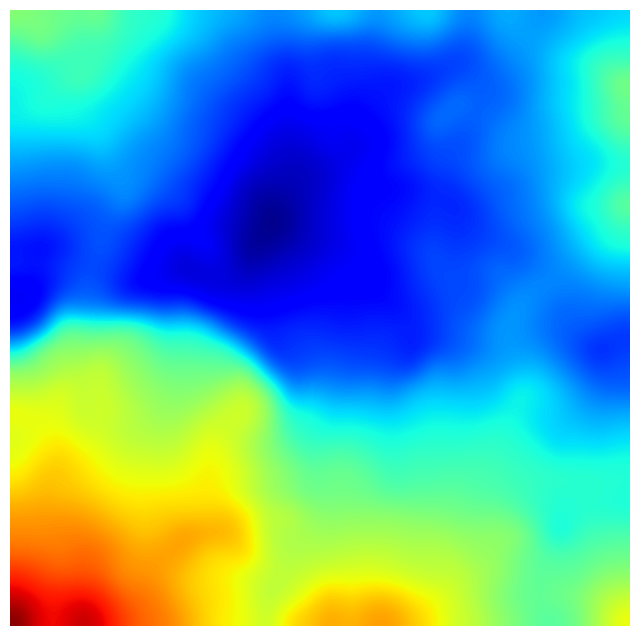

<module 'matplotlib.pyplot' from '/home/jef19jdw/anaconda3/envs/ds_book/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [5]:
print('activation map')
som.view_activation_map(np.array([[x[700], y[700], z[700]]]), colormap='jet')

The `codebook` member variable contains the 3d NumPy array of the SOM's weights (rows x columns x features).

In [6]:
fig = go.Figure(layout_width=800, layout_height=600, layout_scene_aspectmode='cube')

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker={'size': 2, 'color': [f'rgb({r},{g},{b})' for r, g, b in zip(red, green, blue)]},
    hoverinfo = 'none'
))


for r in range(0, rows):
    fig.add_trace(go.Scatter3d(
        x=som.codebook[r, :, 0], y=som.codebook[r, :, 1], z=som.codebook[r, :, 2],
        mode='lines',
        line={'color': 'rgb(0,0,0)'},
        hoverinfo = 'none'
    ))
for c in range(0, cols):
    fig.add_trace(go.Scatter3d(
        x=som.codebook[:, c, 0], y=som.codebook[:, c, 1], z=som.codebook[:, c, 2],
        mode='lines',
        line={'color': 'rgb(0,0,0)'},
        hoverinfo = 'none'
    ))

fig.show()

The `get_surface_state` methods yields the distances between each pair of weight vector and training sample. Return values is a 2d NumPy array (samples x weights). We may use it to visualize weights in 2d by assigning to each weight the closest training sample.

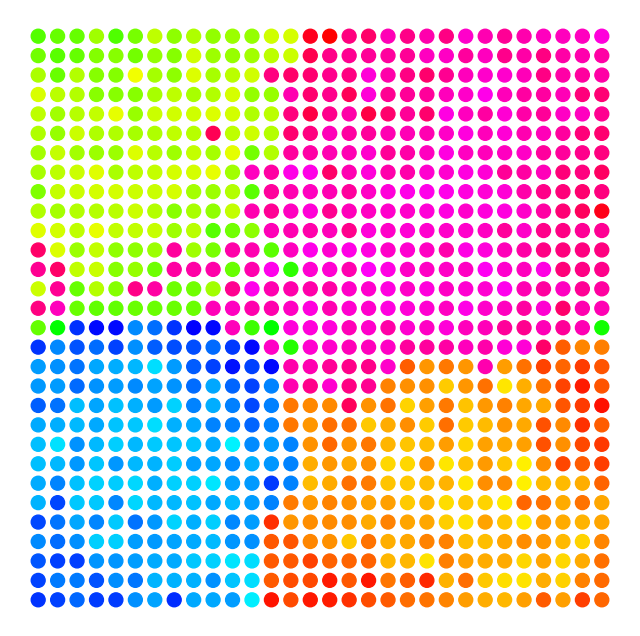

In [7]:
closest_sample = np.argmin(som.get_surface_state(), axis=0).reshape(rows, cols)

u1, u2 = np.meshgrid(np.linspace(0, 1, cols), np.linspace(1, 0, rows))
u1 = u1.reshape(-1)
u2 = u2.reshape(-1)

fig, ax = plt.subplots(figsize=(8, 8))
colors = np.stack((red[closest_sample].reshape(-1), green[closest_sample].reshape(-1), blue[closest_sample].reshape(-1)), axis=1) / 255
ax.scatter(u1, u2, c=colors, s=100)
ax.axis('equal')
ax.axis('off')
plt.show()